<a href="https://colab.research.google.com/github/BrittonWinterrose/DS-Unit-1-Sprint-4-Statistical-Tests-and-Experiments/blob/master/Drug_Data_NLP_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concrete solutions to real problems
## An NLP workshop by Emmanuel Ameisen [(@EmmanuelAmeisen)](https://twitter.com/EmmanuelAmeisen), from Insight AI

While there exist a wealth of elaborate and abstract NLP techniques, clustering and classification should always be in our toolkit as the first techniques to use when dealing with this kind of data. In addition to being amongst some of the easiest to scale in production, their ease of use can quickly help business address a set of applied problems:

- How do you automatically make the distinction between different categories of sentences?
- How can you find sentences in a dataset that are most similar to a given one?
- How can you extract a rich and concise representation that can then be used for a range of other tasks?
- Most importantly, how do you find quickly whether these tasks are possible on your dataset at all?

While there is a vast amount of resources on classical Machine Learning, or Deep Learning applied to images, I've found that there is a lack of clear, simple guides as to what to do when one wants to find a meaningful representation for sentences (in order to classify them or group them together for examples). Here is my attempt below.

## It starts with data

### Our Dataset: Disasters on social media
Contributors looked at over 10,000 tweets retrieved with a variety of searches like “ablaze”, “quarantine”, and “pandemonium”, then noted whether the tweet referred to a disaster event (as opposed to a joke with the word or a movie review or something non-disastrous). Thank you [Crowdflower](https://www.crowdflower.com/data-for-everyone/).

### Why it matters
We will try to correctly predict tweets that are about disasters. This is a very relevant problem, because:
- It is actionable to anybody trying to get signal from noise (such as police departments in this case)
- It is tricky because relying on keywords is harder than in most cases like spam

In [1]:
!pip install gensim
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)


In [2]:
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs

Using TensorFlow backend.


### Sanitizing input
Let's make sure our tweets only have characters we want. We remove '#' characters but keep the words after the '#' sign because they might be relevant (eg: #disaster)

In [3]:
#!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
#!unzip drugsCom_raw.zip


df_train = pd.read_table('drugsComTrain_raw.tsv')
df_test = pd.read_table('drugsComTest_raw.tsv')

df_main = pd.concat([df_train, df_test], axis=0)
df_main.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [4]:
# Turn rating into new "binned" column
def rank_bin(array):
  y_rank = []
  for i in array:
    if i <= 4: # Negative Rating Cut Off (Inclusive)
      y_rank.append(-1)
    elif i >= 10: # Positive Rating Cut Off (Inclusive)
      y_rank.append(1)
    else:
      y_rank.append(0)
  return y_rank

df_main["rank_bin"] = rank_bin(df_main["rating"])
df_main.rank_bin.value_counts() # Check to see the bin sizes. 

 0    93486
 1    68005
-1    53572
Name: rank_bin, dtype: int64

In [0]:
# Upload File Manually
#from google.colab import files

#uploaded = files.upload()

#for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#      name=fn, length=len(uploaded[fn])))

In [0]:
#downloaded = drive.CreateFile({'id': "1m74XhpHHZXfS3mAM8cbBYl-FHlpjZnEi"})
#downloaded.GetContentFile("socialmedia_relevant_cols.csv")

In [0]:
#input_file = codecs.open("socialmedia_relevant_cols.csv", "r",encoding='utf-8', errors='replace')
#output_file = open("socialmedia_relevant_cols_clean.csv", "w")

#def sanitize_characters(raw, clean):    
#    for line in input_file:
#        out = line
#        output_file.write(line)
        
#sanitize_characters(input_file, output_file)

### Let's inspect the data
It looks solid, but we don't really need urls, and we would like to have our words all lowercase (Hello and HELLO are pretty similar for our task)

In [8]:
questions = df_main[['review','rating','rank_bin']]  #pd.read_csv("socialmedia_relevant_cols_clean.csv")
questions.columns=['text', 'rating', 'class_label']
questions.head()

,text,rating,class_label
0,"""It has no side effect, I take it in combinati...",9.0,0
1,"""My son is halfway through his fourth week of ...",8.0,0
2,"""I used to take another oral contraceptive, wh...",5.0,0
3,"""This is my first time using any form of birth...",8.0,0
4,"""Suboxone has completely turned my life around...",9.0,0


In [9]:
questions.tail()

,text,rating,class_label
53761,"""I have taken Tamoxifen for 5 years. Side effe...",10.0,1
53762,"""I&#039;ve been taking Lexapro (escitaploprgra...",9.0,0
53763,"""I&#039;m married, 34 years old and I have no ...",8.0,0
53764,"""I was prescribed Nucynta for severe neck/shou...",1.0,-1
53765,"""It works!!!""",9.0,0


In [10]:
questions.describe()

,rating,class_label
count,215063.000000,215063.000000
mean,6.990008,0.067111
std,3.275554,0.748871
min,1.000000,-1.000000
25%,5.000000,0.000000
50%,8.000000,0.000000
75%,10.000000,1.000000
max,10.000000,1.000000


Let's use a few regular expressions to clean up pour data, and save it back to disk for future use

In [11]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

questions = standardize_text(questions, "text")

questions.to_csv("clean_data.csv")
questions.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

,text,rating,class_label
0,"""it has no side effect, i take it in combinati...",9.0,0
1,"""my son is halfway through his fourth week of ...",8.0,0
2,"""i used to take another oral contraceptive, wh...",5.0,0
3,"""this is my first time using any form of birth...",8.0,0
4,"""suboxone has completely turned my life around...",9.0,0


In [12]:
clean_questions = pd.read_csv("clean_data.csv")
clean_questions.tail()

,Unnamed: 0,text,rating,class_label
215058,53761,"""i have taken tamoxifen for 5 years side effe...",10.0,1
215059,53762,"""i 039 ve been taking lexapro (escitaploprgra...",9.0,0
215060,53763,"""i 039 m married, 34 years old and i have no ...",8.0,0
215061,53764,"""i was prescribed nucynta for severe neck shou...",1.0,-1
215062,53765,"""it works!!!""",9.0,0


### Data Overview

Let's look at our class balance.

In [13]:
clean_questions.groupby("class_label").count()

,Unnamed: 0,text,rating
class_label,,,
-1,53572,53572,53572
0,93486,93486,93486
1,68005,68005,68005


We can see our classes are pretty balanced, with a slight oversampling of the "Irrelevant" class.

### Our data is clean, now it needs to be prepared
Now that our inputs are more reasonable, let's transform our inputs in a way our model can understand. This implies:
- Tokenizing sentences to a list of separate words
- Creating a train test split
- Inspecting our data a little more to validate results

In [14]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)

df_main['review_clean']=clean_questions.text
df_main['tokens']=clean_questions.tokens

clean_questions.head()

,Unnamed: 0,text,rating,class_label,tokens
0,0,"""it has no side effect, i take it in combinati...",9.0,0,"[it, has, no, side, effect, i, take, it, in, c..."
1,1,"""my son is halfway through his fourth week of ...",8.0,0,"[my, son, is, halfway, through, his, fourth, w..."
2,2,"""i used to take another oral contraceptive, wh...",5.0,0,"[i, used, to, take, another, oral, contracepti..."
3,3,"""this is my first time using any form of birth...",8.0,0,"[this, is, my, first, time, using, any, form, ..."
4,4,"""suboxone has completely turned my life around...",9.0,0,"[suboxone, has, completely, turned, my, life, ..."


### Inspecting our dataset a little more

In [15]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
df_main["sentence_length"] = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(df_main["sentence_length"]))

19028335 words total, with a vocabulary size of 53563
Max sentence length is 1992


In [16]:
print(df_main.loc[df_main['sentence_length'] == 1992].review.values)

['"Two and a half months ago I was prescribed Venlafaxine to help prevent chronic migraines.\r\nIt did help the migraines (reduced them by almost half), but with it came a host of side effects that were far worse than the problem I was trying to get rid of.\r\nHaving now come off of the stuff, I would not recommend anyone ever use Venlafaxine unless they suffer from extreme / suicidal depression. I mean extreme in the most emphatic sense of the word. \r\nBefore trying Venlafaxine, I was a writer. While on Venlafaxine, I could barely write or speak or communicate at all. More than that, I just didn&#039;t want to. Not normal for a usually outgoing extrovert.\r\nNow, I&#039;m beginning to write again - but my ability to speak and converse with others has deteriorated by about 95%. Writing these words is taking forever; keeping up in conversation with even one person is impossible, and I barely see the point of trying either. On Venlafaxine, words pretty much left me - my conversational v

In [17]:
_a = df_main.loc[df_main['sentence_length'] >= 1000].review.count()
_b = df_main.loc[df_main['sentence_length'] >= 750].review.count()
_c = df_main.loc[df_main['sentence_length'] >= 250].review.count()
_d = df_main.loc[df_main['sentence_length'] >= 175].review.count()
_e = df_main.loc[df_main['sentence_length'] >= 100].review.count()
_f = df_main.loc[df_main['sentence_length'] < 100].review.count()
print (" # of Reviews by Length \n %s >1000 words \n %s 1000<>700 words \n %s 750<>500 words \n %s 300<>150 words \n %s 200<>100 words \n %s <100 words\n" % (_a,_b,_c,_d,_e,_f))

 # of Reviews by Length 
 6 >1000 words 
 11 1000<>700 words 
 236 750<>500 words 
 549 300<>150 words 
 92881 200<>100 words 
 122182 <100 words



In [23]:
df_short = df_main.loc[df_main['sentence_length'] <= 250]
df_short = df_short.sort_values(by='sentence_length', ascending=False)
print("Max sentence length is %s" % max(df_short["sentence_length"]))

Max sentence length is 250


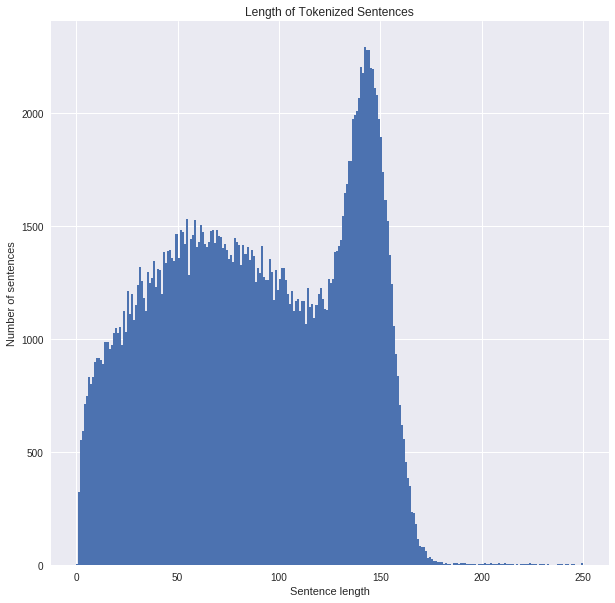

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.title('Length of Tokenized Sentences')
plt.hist(df_short["sentence_length"], bins=250)
plt.show()

In [20]:
a_ = 180
b_ = 175
c_ = 170
d_ = 168
e_ = 167
f_ = 166
g_ = 165
h_ = 165



_a = df_main.loc[df_main['sentence_length'] > a_].review.count()
_b = df_main.loc[df_main['sentence_length'] > b_].review.count()
_c = df_main.loc[df_main['sentence_length'] > c_].review.count()
_d = df_main.loc[df_main['sentence_length'] > d_].review.count()
_e = df_main.loc[df_main['sentence_length'] > e_].review.count()
_f = df_main.loc[df_main['sentence_length'] > f_].review.count()
_g = df_main.loc[df_main['sentence_length'] > g_].review.count()
_h = df_main.loc[df_main['sentence_length'] < h_].review.count()
print (" Cumulative # of Reviews by Length\n %s >%s words \n %s >%s words \n %s >%s words \n %s >%s words \n %s >%s words \n %s >%s words\n %s >%s words\n %s <%s words\n" % (_a,a_,_b,b_,_c,c_,_d,d_,_e,e_,_f,f_,_g,g_,_h,h_))

 Cumulative # of Reviews by Length
 455 >180 words 
 522 >175 words 
 755 >170 words 
 918 >168 words 
 1031 >167 words 
 1210 >166 words
 1439 >165 words
 213390 <165 words



In [21]:
df_shorter = df_main.loc[df_main['sentence_length'] <= 180]
df_shorter = df_shorter.sort_values(by='sentence_length', ascending=False)
print("Max sentence length is %s" % max(df_shorter["sentence_length"]))

Max sentence length is 180


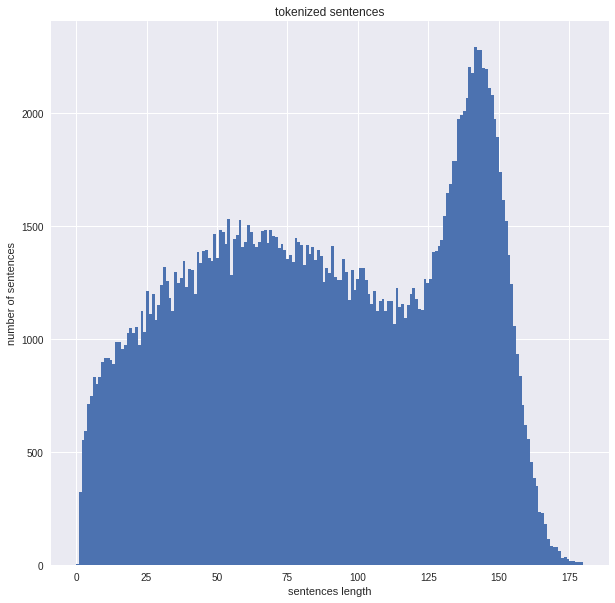

In [91]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('sentences length')
plt.ylabel('number of sentences')
plt.title('tokenized sentences')
plt.hist(df_shorter["sentence_length"], bins=181)
plt.show()

## On to the Machine Learning
Now that our data is clean and prepared, let's dive in to the machine learning part.

## Enter embeddings
 Machine Learning on images can use raw pixels as inputs. Fraud detection algorithms can use customer features. What can NLP use?
 
A natural way to represent text for computers is to encode each character individually, this seems quite inadequate to represent and understand language. Our goal is to first create a useful embedding for each sentence (or tweet) in our dataset, and then use these embeddings to accurately predict the relevant category.

The simplest approach we can start with is to use a bag of words model, and apply a logistic regression on top. A bag of words just associates an index to each word in our vocabulary, and embeds each sentence as a list of 0s, with a 1 at each index corresponding to a word present in the sentence.

## Bag of Words Counts

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = clean_questions["text"].tolist()
list_labels = clean_questions["class_label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

### Visualizing the embeddings
Now that we've created embeddings, let's visualize them and see if we can identify some structure. In a perfect world, our embeddings would be so distinct that are two classes would be perfectly separated. Since visualizing data in 20k dimensions is hard, let's project it down to 2.

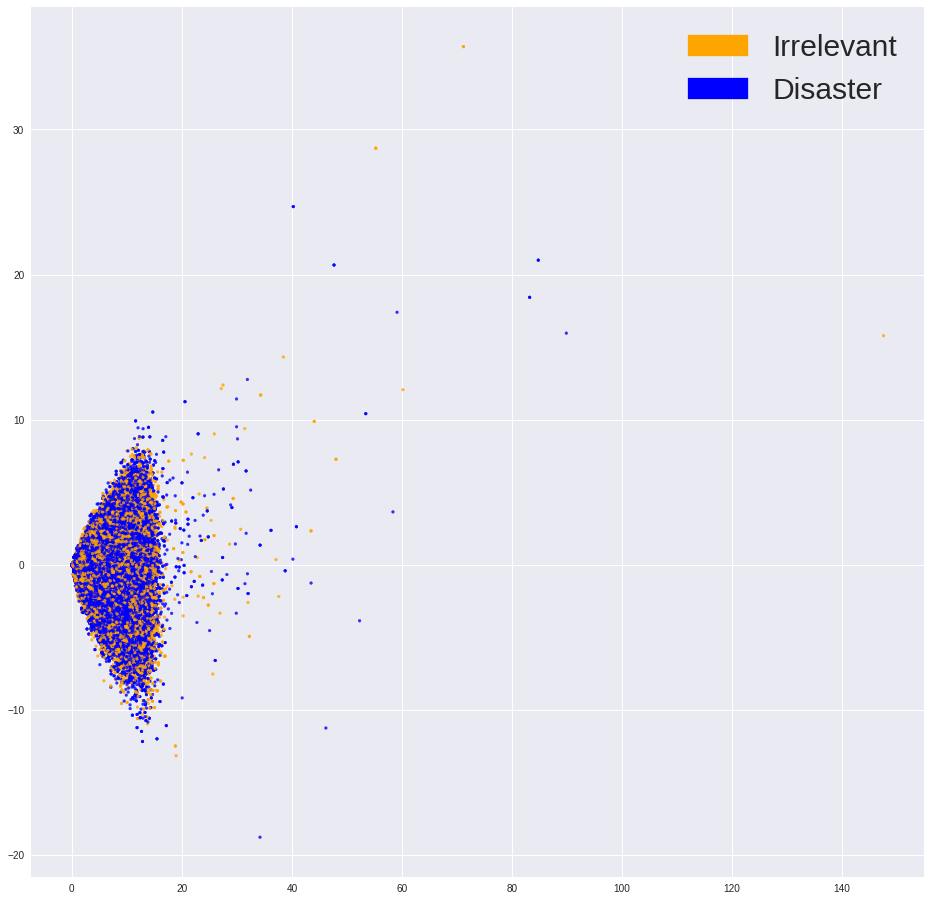

In [77]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

These embeddings don't look very cleanly separated. Let's see if we can still fit a useful model on them.

### Fitting a classifier
Starting with a logistic regression is a good idea. It is simple, often gets the job done, and is easy to interpret.

In [66]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


### Evaluation
Let's start by looking at some metrics to see if our classifier performed well at all.

In [0]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

### Inspection
A metric is one thing, but in order to make an actionnable decision, we need to actually inspect the kind of mistakes our classifier is making. Let's start by looking at the confusion matrix.

In [0]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

In [0]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

Our classifier never predicts class 3, which is not surprising, seeing as it is critically undersampled. This is not very important here, as the label is not very meaningful. Our classifier creates more false negatives than false positives (proportionally). Depending on the use case, this seems desirable (a false positive is quite a high cost for law enforcement for example).

### Further inspection
Let's look at the features our classifier is using to make decisions.

In [0]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

In [0]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Our classifier correctly picks up on some patterns (hiroshima, massacre), but clearly seems to be overfitting on some irellevant terms (heyoo, x1392)

### TFIDF Bag of Words
Let's try a slightly more subtle approach. On top of our bag of words model, we use a TF-IDF (Term Frequency, Inverse Document Frequency) which means weighing words by how frequent they are in our dataset, discounting words that are too frequent, as they just add to the noise.

In [0]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [0]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

These embeddings look much more separated, let's see if it leads to better performance.

In [0]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [0]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

The results are a little better, let's see if they translate to an actual difference in our use case.

In [0]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

Our False positives have decreased, as this model is more conservative about choosing the positive class.

# Looking at important coefficients for linear regression
Insert details here

In [0]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

In [0]:
top_scores = [a[0] for a in importance_tfidf[1]['tops']]
top_words = [a[1] for a in importance_tfidf[1]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[1]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

The words it picked up look much more relevant! Although our metrics on our held out validation set haven't increased much, we have much more confidence in the terms our model is using, and thus would feel more comfortable deploying it in a system that would interact with customers.

### Capturing semantic meaning
Our first models have managed to pick up on high signal words. However, it is unlikely that we will have a training set containing all relevant words. To solve this problem, we need to capture the semantic meaning of words. Meaning we need to understand that words like 'good' and 'positive' are closer than apricot and 'continent'.

### Enter word2vec
Word2vec is a model that was pre-trained on a very large corpus, and provides embeddings that map words that are similar close to each other. A quick way to get a sentence embedding for our classifier, is to average word2vec scores of all words in our sentence.

In [0]:
downloaded = drive.CreateFile({'id': "0B7XkCwpI5KDYNlNUTTlSS21pQmM"})
downloaded.GetContentFile("GoogleNews-vectors-negative300.bin.gz")

In [0]:
import gensim

word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [0]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [0]:
embeddings = get_word2vec_embeddings(word2vec, clean_questions)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

In [0]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(embeddings, list_labels)
plt.show()

These look much more separated, let's see how our logistic regression does on them!

In [0]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [0]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

Still getting better, let's plot the confusion matrix

In [0]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

Our model is strictly better in all regards than the first two models, this is promissing!

### Further inspection
Since our model does not use a vector with one dimension per word, it gets much harder to directly see which words are most relevant to our classification. In order to provide some explainability, we can leverage a black box explainer such as LIME.

In [0]:
!pip install lime

In [0]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)
vector_store = word2vec
def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(count_vectorizer, clf)

In [0]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ["irrelevant","relevant", "unknown"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

In [0]:
visualize_one_exp(X_test_data, y_test_data, 65)

In [0]:
visualize_one_exp(X_test_data, y_test_data, 60)

In [0]:
import random
from collections import defaultdict

random.seed(40)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)
    
    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]    
    
    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'Irrelevant',
    1: 'Relevant',
    2: 'Unsure'
}
sorted_contributions = get_statistical_explanation(X_test_data, 100, word2vec_pipeline, label_to_text)

In [0]:
# First index is the class (Disaster)
# Second index is 0 for detractors, 1 for supporters
# Third is how many words we sample
top_words = sorted_contributions['Relevant']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['Relevant']['supporters'][:10].tolist()
bottom_words = sorted_contributions['Relevant']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['Relevant']['detractors'][:10].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Looks like very relevant words are picked up! This model definitely seems to make decisions in a very understandable way.

# Leveraging text structure
Our models have been performing better, but they completely ignore the structure. To see whether capturing some more sense of structure would help, we will try a final, more complex model.

### CNNs for text classification
Here, we will be using a Convolutional Neural Network for sentence classification. While not as popular as RNNs, they have been proven to get competitive results (sometimes beating the best models), and are very fast to train, making them a perfect choice for this tutorial.

First, let's embed our text!

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 35
VOCAB_SIZE = len(VOCAB)

VALIDATION_SPLIT=.2
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(clean_questions["text"].tolist())
sequences = tokenizer.texts_to_sequences(clean_questions["text"].tolist())

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(clean_questions["class_label"]))

indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

Now, we will define a simple Convolutional Neural Network

In [0]:
from keras.layers import Dense, Input, Flatten, Dropout, Merge
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model

def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = Merge(mode='concat', concat_axis=1)(convs)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)

    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

Now let's train our Neural Network

In [0]:
x_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = cnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM, 
                len(list(clean_questions["class_label"].unique())), False)

In [0]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, batch_size=128)

Our best model yet, at least on the surface. Exploring whether it is really performing as expected using the previous method is left to the reader.

# Takeaways
We now have a solid framework for organizing text data, and training classifiers while efficiently inspecting their results. While we've started to get some interesting results, we are far from having solved NLP!

# Thank you!
Feel free to follow me on [Twitter](https://twitter.com/EmmanuelAmeisen), and find out more about Insight on [our website](insightdatascience.com) and check out our [blog](blog.insightdatascience.com) for more content like this. 